In [3]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.losses import binary_crossentropy

import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from glob import glob
from skimage.transform import resize
from matplotlib.patches import Rectangle

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2024-05-11 14:44:45--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K  52.1KB/s    in 9.3s    

2024-05-11 14:44:59 (52.1 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [5]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [6]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

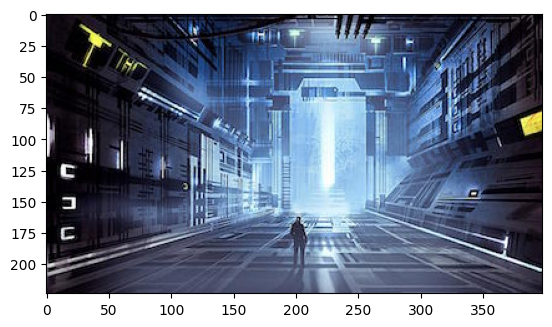

In [7]:
plt.imshow(backgrounds[3])

In [8]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-05-11 14:45:00--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-05-11 14:45:00 (64.4 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



Height of the object image: 56
Width of the object image:  44
Number of color channels: 4


<ipython-input-9-a8b97db4b6ab>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ch = imread(path)


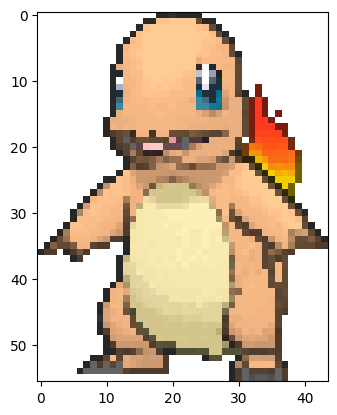

In [9]:
# path = '/home/notomo/Documents/VSC/Models/ObjectLocalization/charmander-tight.png'
path = '/content/charmander-tight.png'
ch = imread(path)

POKE_DIM = 200
ch = np.array(ch)
plt.imshow(ch)
CH_H, CH_W, CH_C = ch.shape

print(f'Height of the object image: {CH_H}')
print(f'Width of the object image:  {CH_W}')
print(f'Number of color channels: {CH_C}')

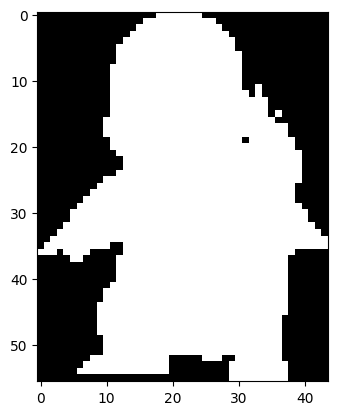

In [10]:
plt.imshow(ch[:, :, 3], cmap='gray')

In [11]:
def customloss(y_true, y_pred):
    # target is (x, y, h, w, appear)
    bce = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
    bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])

    return 2 * bce * y_true[:, -1] + 0.5 * bce2

In [12]:
def make_model():
    vgg = VGG16(input_shape= [POKE_DIM, POKE_DIM, 3],
                include_top=False,
                weights='imagenet')

    x = Flatten()(vgg.output)
    x = Dense(units=5, activation='sigmoid')(x) # 4 neurons corresponding to: x_topleft, y_topleft, height, width
    model = Model(vgg.input, x)
    model.compile(loss=customloss, optimizer=Adam(lr=0.0001))

    return model

In [13]:
def pokemon_generator_appear(batch_size=64):
    while True:
        for _ in range(50): # number of batches in each epoch is just random (I chose 50)
            # Generate X - (batch_size, H, W, 3)
            # Generate y  - (batch_size, 4)
            X = np.zeros(shape=(batch_size, POKE_DIM, POKE_DIM, 3))
            y = np.zeros(shape=(batch_size, 5)) # x_top_right, y_top_right, height, width

            for i in range(batch_size):
                bg_idx = np.random.choice(len(backgrounds))
                bg = backgrounds[bg_idx]
                bg_h, bg_w, _ = bg.shape

                # Cut a random part on background image (200x200)
                cut_x = np.random.randint(0, bg_w - POKE_DIM)
                cut_y = np.random.randint(0, bg_h - POKE_DIM)
                X[i] = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

                appear = (np.random.random() < 0.5)
                if appear:
                    # Resize Object (random)
                    scale = np.random.random() + 0.5
                    new_height, new_width = int(CH_H * scale), int(CH_W * scale)
                    obj = resize(ch, (new_height, new_width),
                                preserve_range=True).astype(np.uint8)

                    # Flip Object
                    if np.random.random() < 0.5:
                        obj = np.fliplr(obj)

                    # Locate the object on background image (at a random location)
                    x0 = np.random.randint(0, POKE_DIM - new_width)
                    y0 = np.random.randint(0, POKE_DIM - new_height)
                    x1 = x0 + new_width
                    y1 = y0 + new_height

                    # Paste Object on background image
                    mask = (obj[:, :, 3] == 0) # find where the object is 0
                    bg_obj = X[i, y0:y0+new_height, x0:x0+new_width, :] # where we want to place `obj`
                    bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
                    bg_obj += obj[:, :, :3]
                    X[i, y0:y0+new_height, x0:x0+new_width, :] = bg_obj

                    y[i, 0] = x0 / POKE_DIM
                    y[i, 1] = y0 / POKE_DIM
                    y[i, 2] = (y1-y0) / POKE_DIM
                    y[i, 3] = (x1-x0) / POKE_DIM
                y[i, 4] = appear
            yield X / 255., y

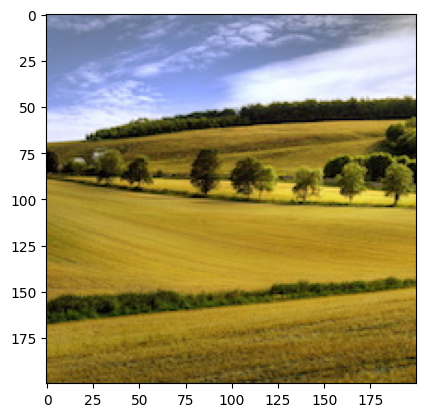

In [14]:
# Testing the function
xx = None
yy = None
for x, y in pokemon_generator_appear():
    xx = x
    yy = x
    break
plt.imshow(xx[5])

In [16]:
model = make_model()
model.fit_generator(
    pokemon_generator_appear(),
    steps_per_epoch=50,
    epochs=5
)

58889256/58889256 [==============================] - 4s 0us/step


<ipython-input-16-5c803f7595a4>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/5
50/50 [==============================] - 74s 668ms/step - loss: 1.1582
Epoch 2/5
50/50 [==============================] - 34s 690ms/step - loss: 0.9363
Epoch 3/5
50/50 [==============================] - 34s 689ms/step - loss: 0.8123
Epoch 4/5
50/50 [==============================] - 34s 687ms/step - loss: 0.5594
Epoch 5/5
50/50 [==============================] - 34s 688ms/step - loss: 0.5446


1/1 [==============================] - 0s 31ms/step
pred: 95 16 152 58


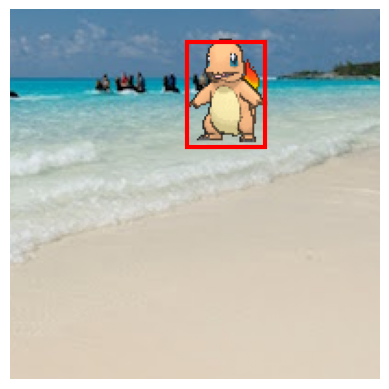

In [32]:
# Function to make prediction, everytime want to test the model, just run this function
def pokemon_predict_appear():
    X = np.zeros(shape=(POKE_DIM, POKE_DIM, 3))
    y = np.zeros(shape=(5)) # x_top_right, y_top_right, height, width

    bg_idx = np.random.choice(len(backgrounds))
    bg = backgrounds[bg_idx]
    bg_h, bg_w, _ = bg.shape

    # Cut a random part on background image (200x200)
    cut_x = np.random.randint(0, bg_w - POKE_DIM)
    cut_y = np.random.randint(0, bg_h - POKE_DIM)
    X = bg[cut_y:cut_y+POKE_DIM, cut_x:cut_x+POKE_DIM, :].copy()

    appear = (np.random.random() < 0.5)
    if appear:
        # Resize Object (random)
        scale = np.random.random() + 0.5
        new_height, new_width = int(CH_H * scale), int(CH_W * scale)
        obj = resize(ch, (new_height, new_width),
                    preserve_range=True).astype(np.uint8)

        # Flip Object
        if np.random.random() < 0.5:
            obj = np.fliplr(obj)

        # Locate the object on background image (at a random location)
        x0 = np.random.randint(0, POKE_DIM - new_width)
        y0 = np.random.randint(0, POKE_DIM - new_height)
        x1 = x0 + new_width
        y1 = y0 + new_height

        # Paste Object on background image
        mask = (obj[:, :, 3] == 0) # find where the object is 0
        bg_obj = X[y0:y0+new_height, x0:x0+new_width, :] # where we want to place `obj`
        bg_obj = np.expand_dims(mask, -1) * bg_obj # (h,w,1) x (h,w,3)
        bg_obj += obj[:, :, :3]
        X[y0:y0+new_height, x0:x0+new_width, :] = bg_obj

        y[0] = x0 / POKE_DIM
        y[1] = y0 / POKE_DIM
        y[2] = (y1-y0) / POKE_DIM
        y[3] = (x1-x0) / POKE_DIM

    y[4] = appear
    X = np.expand_dims(X, axis=0) / 255.
    y = np.expand_dims(y, axis=0)
    prediction = model.predict(X)[0]

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X[0])

    if prediction[4] > 0.5:
        prediction = prediction * POKE_DIM
        row0 = int(prediction[0])
        col0 = int(prediction[1])
        row1 = int(row0 + prediction[2])
        col1 = int(col0 + prediction[3])
        print("pred:", row0, col0, row1, col1)

        rect = Rectangle((prediction[0], prediction[1]),
                        height=prediction[2], width=prediction[3],
                        edgecolor='r',
                        linewidth=3,
                        facecolor='none')

        ax.add_patch(rect)
    else:
        print('pred: No Object')

    plt.show()


# Run function
pokemon_predict_appear()